# VGG for MNIST classification

VGG implementation as TFModel

In [1]:
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append("../..")
sys.path.append("../base_networks/classification/")

from dataset import B, C, F, V, Pipeline, DatasetIndex
from dataset.dataset.opensets import MNIST
from dataset.dataset.models.tf.vgg import VGG7

%matplotlib inline

Define constants

In [2]:
BATCH_SIZE = 64
IMAGE_SIZE = 28

Create class for MNIST data and load it

In [3]:
mnist = MNIST()

ExtractingExtractingExtractingExtracting    C:\Users\kozhevin\AppData\Local\Temp\t10k-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-labels-idx1-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\train-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\train-labels-idx1-ubyte.gz





Create configuration dictionary for placegolders

In [4]:
placeholders_config = {
                       'images': {'shape': (IMAGE_SIZE, IMAGE_SIZE, 1),
                                 'type': 'float32',
                                 'data_format': 'channels_last'},
                
                       'labels': {'shape': 10,
                                 'dtype': 'int32',
                                  'transform': 'ohe',
                               #   'data_format': 'channels_last',
                                 'name': 'targets'}
                       }

In [5]:
model_config = {'inputs': placeholders_config,
                'loss': 'softmax_cross_entropy',
                'optimizer': 'Adam'}

train_feed_dict = {'images': B('images'),
                   'labels': B('labels')}        

test_feed_dict = {'images': B('images'),
                  'labels': B('labels')}

In [6]:
train_pp = (mnist.train.p
            .init_model('static', VGG7, 'VGG', config=model_config)
            .init_variable('loss_history', init_on_each_run=list)
            .train_model('VGG', fetches=['loss'], feed_dict=train_feed_dict, save_to=V('loss_history'), mode='e'))

test_pp = (mnist.test.p
            .import_model('VGG', train_pp)
            .init_variable('predicted_proba', init_on_each_run=list)
            .predict_model('VGG', 
                           fetches=['predicted_proba'], 
                           feed_dict=test_feed_dict, 
                           save_to=[V('predicted_proba')], 
                           mode='a'))

acc = []

for i in tqdm(range(100)):
    train_pp.next_batch(BATCH_SIZE, shuffle=True, n_epochs=None, drop_last=False)
    batch = test_pp.next_batch(BATCH_SIZE, shuffle=True, n_epochs=None, drop_last=False)
    acc.append(np.mean(np.argmax(np.array(test_pp.get_variable('predicted_proba')[-1]), axis=-1) == batch.data.labels))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.33it/s]


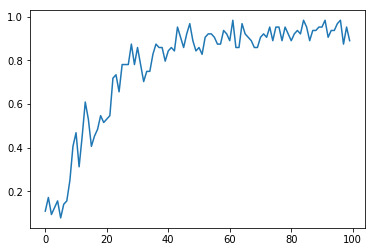

In [7]:
plt.plot(acc)
plt.show()